<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarc.csv.gz
test-unbalanced.csv  train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [8]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

# **Part 1. Exploratory Data Analysis**

Distribution of length for sarcastic and normal comments: 

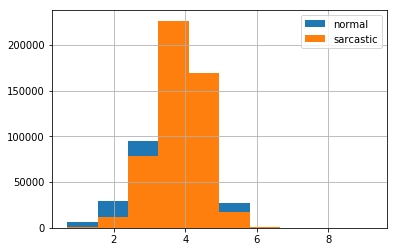

In [9]:
train_df[train_df['label'] == 0]['comment'].str.len().describe()
train_df[train_df['label'] == 0]['comment'].str.len().apply(np.log1p).describe()
train_df[train_df['label'] == 0]['comment'].str.len().apply(np.log1p).hist(label='normal');
train_df[train_df['label'] == 1]['comment'].str.len().apply(np.log1p).hist(label='sarcastic');
plt.legend();

Count of sarcastic and normal comments for subreddits: 

In [10]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


Analyzing score feature.

In [11]:
score_df = train_df.groupby('score')['label'].describe()
score_df[score_df['count'] > 100].sort_values(by='mean', ascending=False).head(15)

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
-20,222.0,0.729730,0.445103,0.0,0.0,1.0,1.0,1.0
-23,175.0,0.720000,0.450287,0.0,0.0,1.0,1.0,1.0
-14,537.0,0.698324,0.459413,0.0,0.0,1.0,1.0,1.0
-8,1852.0,0.696004,0.460105,0.0,0.0,1.0,1.0,1.0
-22,197.0,0.695431,0.461397,0.0,0.0,1.0,1.0,1.0
-9,1503.0,0.691284,0.462117,0.0,0.0,1.0,1.0,1.0
-6,3088.0,0.688795,0.463061,0.0,0.0,1.0,1.0,1.0
-12,776.0,0.684278,0.465102,0.0,0.0,1.0,1.0,1.0
-5,4134.0,0.678520,0.467101,0.0,0.0,1.0,1.0,1.0


# **Part 2. Training the model**

**Result with CountVectorizer(just count words, Bag of words)**

In [12]:
cv = CountVectorizer('''stop_words = stopwords.words('english')''')
cv.fit(train_texts)
print(len(cv.vocabulary_))
X_train = cv.transform(train_texts)
X_valid = cv.transform(valid_texts)


logit = LogisticRegression(n_jobs=-1, random_state=17, solver="lbfgs", verbose=1)
logit.fit(X_train, y_train)
print(round(logit.score(X_train, y_train), 3), round(logit.score(X_valid, y_valid), 3))

143306


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.4s finished


0.711 0.693


' CHECK\n1) Sparse matrices\n2) logit C hyperparameter\n3) sklearn pipelines +\n4) scikit learn tf-idf +'

**Result with Tf-idf.** \
**Result is a little bit better.**

In [13]:
%%time
tf_idf = TfidfVectorizer(min_df = 2, max_features=50000, ngram_range=(1,2)) # max_features - limit len of vocabulary
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])
tfidf_logit_pipeline.fit(train_texts, y_train)

valid_pred = tfidf_logit_pipeline.predict(valid_texts)

print(accuracy_score(y_valid, valid_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.7s finished


0.7208560551497067
CPU times: user 48.7 s, sys: 1.23 s, total: 49.9 s
Wall time: 1min 12s
